# 인공지능 프로젝트

### 유튜브 소개 영상: [Youtube Link](https://youtu.be/BGcJGCGU1ok)

# 목차  
- League Of Legends 데이터 수집
- League Of Legends 데이터 전처리
- 실험 1: League Of Legends, Middle 포지션 유저의 승패 예측 모델 생성
- 실험 2: League Of Legends, 유저의 포지션 예측 모델 생성
- 실험 3: League Of Legends, 유저의 획득 골드 예측 모델 생성
- 실험 4: 동물 이미지로 이름 예측 모델 생성

# League Of Legends 데이터 수집  
  
League Of Legends 사이트에서 제공되는 API와 Token을 통해 데이터를 수집할 수 있다.  
수집한 데이터는 Pandas 라이브러리를 통해 DataFrame 타입 변수에 저장하고 마지막으로 Excel 파일의 형태로 저장한다.

In [32]:
import pandas as pd
from datetime import datetime
import os, os.path, json, requests
from time import sleep

HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.106 Safari/537.36",
    "Accept-Language": "ko-KR,ko;q=0.9,en-US;q=0.8,en;q=0.7",
    "Accept-Charset": "application/x-www-form-urlencoded; charset=UTF-8",
    "Origin": "https://developer.riotgames.com",
    "X-Riot-Token": "" # Auth Token
}

USER_FILE = './user.json'
MATCH_FILE_PATH = './matches/'
MATCHINFO_FILE_PATH = './matchInfo/'
EXCEL_PATH = './data.xlsx'

USER_NAME = ''      # 데이터를 수집할 유저명, 리스트로도 구성 가능
START_INDEX = 900   # 데이터의 시작 인덱스

##### API #####
def _get(url):
    res = requests.get(url, headers=HEADERS).json()
    return res

def _userInfo(summonerName):
    url = f'https://kr.api.riotgames.com/lol/summoner/v4/summoners/by-name/{summonerName}'
    res = _get(url)
    if 'status' in res:
        print('userInfo : ' + res['status']['message'])
    return res

def _matches(puuid, start=0, count=100):
    url = f'https://asia.api.riotgames.com/lol/match/v5/matches/by-puuid/{puuid}/ids?start={start}&count={count}'
    res = _get(url)
    if 'status' in res:
        print('_matches : ' + res['status']['message'])
    return res

def _matchInfo(matchId):
    url = f'https://asia.api.riotgames.com/lol/match/v5/matches/{matchId}'
    res = _get(url)
    if 'status' in res:
        print('_matchInfo : ' + res['status']['message'])
    return res

##### Function #####
# 타임 스탬프 형식을 요일 형식으로 변환한다
def timestampToWeekday(timestamp):
    date = datetime.fromtimestamp(timestamp / 1000)
    week = date.weekday()
    return week

# 유저의 정보를 읽어온다. 드라이브에 해당 유저명의 json 파일이 없을 경우 API를 통해 읽어오고 드라이브에 저장한다
def userInfo(summonerName=USER_NAME):
    try:
        with open(USER_FILE, 'r') as json_file:
            json_data = json.load(json_file)
            if json_data['name'].lower() == summonerName.lower(): return json_data
    except: pass
    json_data = _userInfo(summonerName)
    with open(USER_FILE, 'w') as json_file:
        json.dump(json_data, json_file, indent=3)
    return json_data

# 유저의 매칭 리스트를 읽어온다. 드라이브에 해당 유저명의 json 파일이 없을 경우 API를 통해 읽어오고 드라이브에 저장한다
# 매칭 리스트: 유저들이 매칭되어 진행된 게임을 줄여 매칭이라고 하며, 매칭 리스트는 각 매칭의 고유 아이디를 포함하고 있다 
def matches(puuid, start=START_INDEX, count=100):
    file_path = MATCH_FILE_PATH + f'{USER_NAME}_{start}_{start+count}.json'
    try:
        with open(file_path, 'r') as json_file:
            json_data = json.load(json_file)
            return json_data
    except: pass
    json_data = _matches(puuid, start, count)
    with open(file_path, 'w') as json_file:
        json.dump(json_data, json_file, indent=3)
    return json_data

# 매칭 정보를 json 형식으로 저장한다
def saveMatchInfo(matchId):
    dir_path = MATCHINFO_FILE_PATH + USER_NAME + '/'
    try: os.mkdir(dir_path)
    except: pass
    file_path = dir_path + matchId + '.json'
    json_data = _matchInfo(matchId)
    with open(file_path, 'w') as json_file:
        json.dump(json_data, json_file, indent=3)

# 지정한 유저의 정보 및 매칭 정보들을 json 형식으로 저장한다
def saveDataLogic(userName=USER_NAME):
    puuid = userInfo(userName)['puuid']
    for i, matchId in enumerate(matches(puuid)):
        saveMatchInfo(matchId)
        print(i + 1) # 진행 상태 확인
        sleep(0.2)        

# 지정한 유저의 json 형식으로 저장되있는 매칭 정보들을 읽어온다
def matchInfo(userName=USER_NAME):
    data = []
    if userName.lower() == 'all':
        for dir in os.listdir(MATCHINFO_FILE_PATH):
            data += matchInfo(dir)
        return data
    if type(userName) == type([]):
        for name in userName:
            data += matchInfo(name)
        return data
    dir_path = MATCHINFO_FILE_PATH + userName
    for currentdir,dirs,files in os.walk(dir_path):
        for filename in files:
            file_path = dir_path + '/' + filename
            with open(file_path, 'r') as json_file:
                json_data = json.load(json_file)
                data.append(json_data)
    return data

# matchInfo 를 통해 읽어온 매칭 정보들을 엑셀로 변환한다
def toExcel(matchInfoList):
    COLUMNS = ['weekday', 'timePlayed', 'earlySurrender']
    COLUMNS2 = ['kills', 'deaths', 'assists', 'champLevel', 'championName', 'firstBloodKill', 'goldEarned', 'individualPosition', 'summonerName','totalDamageDealtToChampions', 'totalDamageTaken', 'totalMinionsKilled', 'visionWardsBoughtInGame', 'win']
    data = []
    for info in [match['info'] for match in matchInfoList if not 'status' in match]:
        if info['gameMode'] != 'CLASSIC' or info['gameType'] != 'MATCHED_GAME': continue
        weekday = timestampToWeekday(info['gameStartTimestamp'])
        timePlayed = info['participants'][0]['timePlayed']
        earlySurrender = info['participants'][0]['gameEndedInEarlySurrender']
        for user in info['participants']:
            row = [weekday, timePlayed, earlySurrender]
            for col in COLUMNS2:
                row.append(user[col])
            data.append(row)
    df = pd.DataFrame(data, columns=COLUMNS+COLUMNS2)
    df.to_excel(EXCEL_PATH)

##### Main #####
if __name__ == "__main__":
    # saveDataLogic()           # 데이터 수집
    toExcel(matchInfo('all'))   # 엑셀 변환

 # 데이터 전처리

### 데이터 불러오기

In [1]:
import pandas as pd

EXCEL_PATH = './data.xlsx'
df = pd.read_excel(EXCEL_PATH, index_col=0)
df

weekday  timePlayed  earlySurrender  kills  deaths  assists  \
0            5        2050           False      9       6       14   
1            5        2050           False     16       5       13   
2            5        2050           False     10       7       14   
3            5        2050           False      9       6       12   
4            5        2050           False      7       5       25   
...        ...         ...             ...    ...     ...      ...   
34635        5        1298           False      2       2        4   
34636        5        1298           False      8       2        4   
34637        5        1298           False      4       2        6   
34638        5        1298           False      6       2        8   
34639        5        1298           False      3       1       15   

       champLevel championName  firstBloodKill  goldEarned individualPosition  \
0              17     Malphite           False       11821                TOP   
1              18       Graves           False       17274             JUNGLE   
2              17  TwistedFate           False       15465             MIDDLE   
3              16     Tristana           False       16835             BOTTOM   
4              16         Rell            True       11895            UTILITY   
...           ...          ...             ...         ...                ...   
34635          13       Kennen           False        6682                TOP   
34636          13       Ezreal           False        9113             MIDDLE   
34637          12        Viego           False        7929             JUNGLE   
34638          12        Vayne           False        9301             BOTTOM   
34639          10         Lulu            True        6626            UTILITY   

      summonerName  totalDamageDealtToChampions  totalDamageTaken  \
0             노곤조곤                        21450             27205   
1             None                        30827             31165   
2              강 쮸                        23580             28181   
3            우리말지킴                        29138             28989   
4               쥬단                        15011             28088   
...            ...                          ...               ...   
34635         꼬북눈나                        13108              9487   
34636         None                        17626              9245   
34637          강 쮸                         8715             18715   
34638        우리말지킴                        16111              8540   
34639           쥬단                         3662              6074   

       totalMinionsKilled  visionWardsBoughtInGame   win  
0                     119                        2  True  
1                      57                        4  True  
2                     156                        3  True  
3                     227                        5  True  
4                      49                        8  True  
...                   ...                      ...   ...  
34635                 112                        1  True  
34636                 152                        4  True  
34637                  22                        9  True  
34638                 140                        3  True  
34639                  26                        5  True  

[34640 rows x 17 columns]

### 데이터 칼럼 변경

In [2]:
COLUMNS = ['요일', '게임시간', '빠른항복', '킬', '데스', '어시스트', '레벨', '캐릭터', '첫킬', '돈', '역할', '닉네임', '가한피해량', '받은피해량', '포인트', '구매한 와드 수', '승리']
df.columns = COLUMNS
df.head(10)

요일  게임시간   빠른항복   킬  데스  어시스트  레벨          캐릭터     첫킬      돈       역할  \
0   5  2050  False   9   6    14  17     Malphite  False  11821      TOP   
1   5  2050  False  16   5    13  18       Graves  False  17274   JUNGLE   
2   5  2050  False  10   7    14  17  TwistedFate  False  15465   MIDDLE   
3   5  2050  False   9   6    12  16     Tristana  False  16835   BOTTOM   
4   5  2050  False   7   5    25  16         Rell   True  11895  UTILITY   
5   5  2050  False   7  14    10  16       Rumble  False  13498      TOP   
6   5  2050  False   3   8    11  16      Morgana  False  10810   JUNGLE   
7   5  2050  False  13   7     3  17         Fizz  False  15104   MIDDLE   
8   5  2050  False   5  11     9  14     Pantheon  False   8921  UTILITY   
9   5  2050  False   1  11     7  14        Varus  False   9173   BOTTOM   

       닉네임  가한피해량  받은피해량  포인트  구매한 와드 수     승리  
0     노곤조곤  21450  27205  119         2   True  
1     None  30827  31165   57         4   True  
2      강 쮸  23580  28181  156         3   True  
3    우리말지킴  29138  28989  227         5   True  
4       쥬단  15011  28088   49         8   True  
5   북미 판다곰  33537  39651  193         1  False  
6    TET D  20183  33978   39         4  False  
7   프로즌윈터러  25428  24515  187         9  False  
8    MaBom  15378  25604   43         8  False  
9  어른이된감독님  13805  20886  169         1  False

### 데이터 전처리

In [3]:
from sklearn.preprocessing import LabelEncoder
from numpy import digitize
import datetime

# bool, string 데이터 라벨링
lr = LabelEncoder()
labeling_target = ['빠른항복', '첫킬', '역할', '승리']
for label in labeling_target:
    df[label] = lr.fit_transform(df[label])

# 요일: 월,화,수 / 목,금 / 토,일
df.요일 = digitize(df.요일, [0, 3, 5, 7])

df

요일  게임시간  빠른항복   킬  데스  어시스트  레벨          캐릭터  첫킬      돈  역할    닉네임  \
0       3  2050     0   9   6    14  17     Malphite   0  11821   4   노곤조곤   
1       3  2050     0  16   5    13  18       Graves   0  17274   2   None   
2       3  2050     0  10   7    14  17  TwistedFate   0  15465   3    강 쮸   
3       3  2050     0   9   6    12  16     Tristana   0  16835   1  우리말지킴   
4       3  2050     0   7   5    25  16         Rell   1  11895   5     쥬단   
...    ..   ...   ...  ..  ..   ...  ..          ...  ..    ...  ..    ...   
34635   3  1298     0   2   2     4  13       Kennen   0   6682   4   꼬북눈나   
34636   3  1298     0   8   2     4  13       Ezreal   0   9113   3   None   
34637   3  1298     0   4   2     6  12        Viego   0   7929   2    강 쮸   
34638   3  1298     0   6   2     8  12        Vayne   0   9301   1  우리말지킴   
34639   3  1298     0   3   1    15  10         Lulu   1   6626   5     쥬단   

       가한피해량  받은피해량  포인트  구매한 와드 수  승리  
0      21450  27205  119         2   1  
1      30827  31165   57         4   1  
2      23580  28181  156         3   1  
3      29138  28989  227         5   1  
4      15011  28088   49         8   1  
...      ...    ...  ...       ...  ..  
34635  13108   9487  112         1   1  
34636  17626   9245  152         4   1  
34637   8715  18715   22         9   1  
34638  16111   8540  140         3   1  
34639   3662   6074   26         5   1  

[34640 rows x 17 columns]

# 실험 1

역할이 MIDDLE(3)인 플레이어가 '승리'하기위한 주요 요인을 분석하고  
데이터를 주었을때 승패를 예측하는 모델 생성

In [65]:
# 데이터 전처리
df_mid = df[df.역할==3].copy() # 데이터 복사
df_mid.index=range(len(df_mid))  # index 정돈 (1, 2, 3 ...)
df_mid.drop(['닉네임', '캐릭터', '요일', '게임시간', '역할', '빠른항복'], axis=1, inplace=True) # 불필요한 데이터 제거

# 비교를 위해 데이터를 상대편과의 상대적 수치로 변경
columns = ['상대적_킬', '상대적_데스', '상대적_어시스트', '상대적_레벨', 
'첫킬', '상댸적_돈', '상대적_가한피해량', '상대적_받은피해량', 
'상대적_포인트', '상대적_구매한 와드 수', '승리']
df_mid.columns = columns
for idx in range(0, len(df_mid), 2):
    for col in set(columns) - set(['승리', '첫킬']): 
        tmp = df_mid.iloc[idx][col]
        df_mid.iloc[idx][col] -= df_mid.iloc[idx+1][col] 
        df_mid.iloc[idx+1][col] -= tmp
df_mid

상대적_킬  상대적_데스  상대적_어시스트  상대적_레벨  첫킬  상댸적_돈  상대적_가한피해량  상대적_받은피해량  \
0        -3       0        11       0   0    361      -1848       3666   
1         3       0       -11       0   0   -361       1848      -3666   
2         0       2        -2       0   0   -178      -1292       4540   
3         0      -2         2       0   0    178       1292      -4540   
4         6      -4         4       2   0   2188       4783        -68   
...     ...     ...       ...     ...  ..    ...        ...        ...   
6897      4      -3         5       2   0   2516      13954      -8024   
6898     -2       7        -3       1   0    774       3881       3050   
6899      2      -7         3      -1   1   -774      -3881      -3050   
6900     -4       1        -3      -1   0   -927      -9019       8021   
6901      4      -1         3       1   0    927       9019      -8021   

      상대적_포인트  상대적_구매한 와드 수  승리  
0         -31            -6   1  
1          31             6   0  
2          10            -3   0  
3         -10             3   1  
4           8             0   1  
...       ...           ...  ..  
6897       31             0   1  
6898       85            -4   0  
6899      -85             4   1  
6900        2            -2   0  
6901       -2             2   1  

[6902 rows x 11 columns]

데이터간 상관관계를 렌더링하여 승리를 위해서는 어떤 데이터를 높이고, 어떤 데이터를 낮춰야하는지 볼 수 있다  
단순히 통계치로 보았을때 킬, 어시스트, 돈, 레벨, 가한피해량을 높이고 데스를 낮추면 승리할 확률이 높다

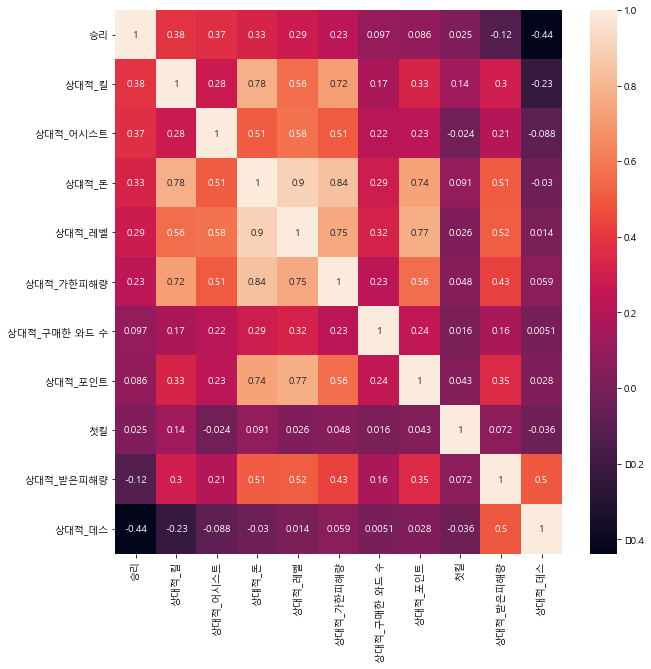

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
def plotCorr(df,col,K=10,ascending = False):
    plt.rc('font', family='Malgun Gothic')
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10)
    corrmat = df.corr()
    cols = corrmat.nsmallest(K,'승리')['승리'].index if ascending else corrmat.nlargest(K,'승리')['승리'].index
    cm = np.corrcoef(df[cols].values.T)
    sns.heatmap(cm,cbar=True,annot=True,yticklabels=cols.values,xticklabels=cols.values,annot_kws={'size':10})
    plt.show()
plotCorr(df_mid, df_mid.columns, len(df_mid.columns))

xgboost와 GridSearchCV를 이용하여 승패 예측모델 생성

In [69]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

x_data = df_mid.drop('승리', axis=1)
y_data = df_mid.승리
x_train, x_test, y_train, y_test= train_test_split(x_data, y_data, test_size=0.3, random_state=123)

xgb_model =  xgb.XGBClassifier(max_depth=6,
                              colsample_bytree=0.7,
                              n_estimators=3000,
                              scale_pos_weight = 9,
                              learning_rate=0.3,
                              objective='binary:logistic', 
                              verbosity=1,
                              eval_metric ='auc',
                              tree_method='gpu_hist',
                              n_jobs=-1,
                              use_label_encoder=False)
xgb_param_grid = {'max_depth': [3,5,7], 
              'subsample': [0.6, 0.8, 1.0]}
hr_grid = GridSearchCV(estimator=xgb_model,
                       param_grid=xgb_param_grid,
                       scoring='roc_auc',
                       n_jobs=4,
                       cv=3,
                       refit=True, 
                       return_train_score=True)                

hr_grid.fit(x_train, y_train)

생성된 모델 평가

In [12]:
def grid_result(grid_model):
    best_model = grid_model.best_estimator_
    pred = best_model.predict(x_test)
    report = classification_report(y_test, pred)
    accuracy = round(float(accuracy_score(y_test, pred)) * 100, 2)
    print('================== GridsearchCV 결과 ==================')
    print('최적 파라미터: {0}'.format(grid_model.best_params_))
    print('최고 점수: {0}'.format(grid_model.best_score_))
    print('====================== 모델 분석 ======================')
    print(report)
    print('======================= 정확도 =======================')
    print(str(accuracy) + '%')
grid_result(hr_grid)

================== GridsearchCV 결과 ==================
최적 파라미터: {'max_depth': 5, 'subsample': 1.0}
최고 점수: 0.9330132023914746
====================== 모델 분석 ======================
              precision    recall  f1-score   support

           0       0.88      0.79      0.84      1044
           1       0.81      0.89      0.85      1027

    accuracy                           0.84      2071
   macro avg       0.85      0.84      0.84      2071
weighted avg       0.85      0.84      0.84      2071

======================= 정확도 =======================
84.36%


승패 여부를 결정짓는 데이터별 중요도 시각화

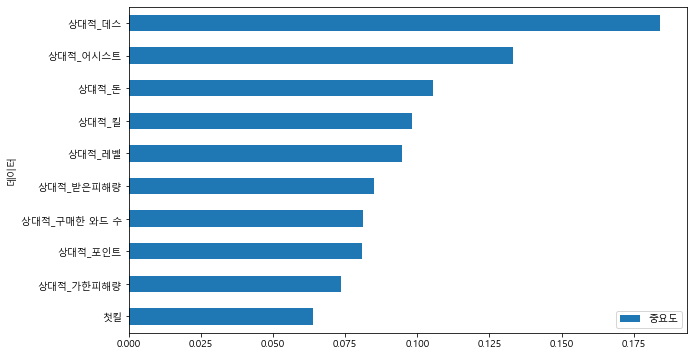

<Figure size 1800x1080 with 0 Axes>

In [26]:
plt.rcParams["figure.figsize"] = (10,6)
df_importance = pd.DataFrame(hr_grid.best_estimator_.feature_importances_, columns=['중요도'])
df_importance['데이터'] = x_data.columns
df_importance.sort_values(by=['중요도'], ascending=True, inplace=True)
df_importance.plot.barh(x='데이터', y='중요도')
plt.figure(figsize=(25, 15))
plt.show()

실제 무작위 데이터를 추출하여 예측

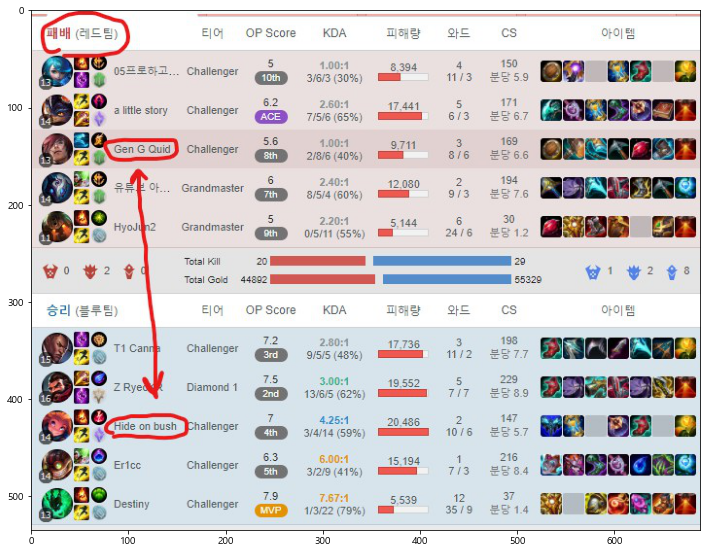

패배


In [27]:
import matplotlib.image as img

image = img.imread('./imgs/experiment_1.jpg')
plt.figure(figsize=(12,12))
plt.imshow(image)
plt.show()

x = [[-1,4,-8,-1,0,-100,-11000,14000,2020,-2]]
df_test = pd.DataFrame(x, columns=x_data.columns)
result = hr_grid.predict_proba(df_test)
print('==================================')
if (result[0][0] > result[0][1]): print('패배')
else: print('승리')
print('==================================')

## 실험1 결론  
게임내 역할중 하나인 'MIDDLE'은 한국어로 '중심' 또는 '허리'라 불린다.  
말그대로 팀의 중심이 되는 역할로  
앞에 나서는것보다 덜 죽으면서 게임 전체적으로 기여하다가  
돈을 모아 성장하여 후반을 도모하는 방식의 플레이가  
승리확률이 높다는 결과가 도출된다.

# 실험 2  
데이터를 통해 해당 게임의 유저가 어떤 '역할'을 하였는지 예측하는 모델 생성

In [28]:
# 데이터 전처리
df_position = df.copy() # 데이터 복사
df_position.drop(['닉네임', '캐릭터', '요일', '게임시간', '빠른항복', '승리'], axis=1, inplace=True) # 불필요한 데이터 제거

# 비교를 위해 데이터를 같은편 데이터 평균의 상대적 수치로 변경
columns = ['상대적_킬', '상대적_데스', '상대적_어시스트', '상대적_레벨', 
'첫킬', '상댸적_돈', '역할', '상대적_가한피해량', '상대적_받은피해량', 
'상대적_포인트', '상대적_구매한 와드 수']
df_position.columns = columns
for idx in range(0, len(df_position), 5):
    for col in set(columns) - set(['역할', '첫킬']): 
        avg = np.mean(df_position.loc[idx:idx+4,col])
        df_position.loc[idx:idx+4,col] -= avg
df_position

상대적_킬  상대적_데스  상대적_어시스트  상대적_레벨  첫킬   상댸적_돈  역할  상대적_가한피해량  상대적_받은피해량  \
0       -1.2     0.2      -1.6     0.2   0 -2837.0   4    -2551.2    -1520.6   
1        5.8    -0.8      -2.6     1.2   0  2616.0   2     6825.8     2439.4   
2       -0.2     1.2      -1.6     0.2   0   807.0   3     -421.2     -544.6   
3       -1.2     0.2      -3.6    -0.8   0  2177.0   1     5136.8      263.4   
4       -3.2    -0.8       9.4    -0.8   1 -2763.0   5    -8990.2     -637.6   
...      ...     ...       ...     ...  ..     ...  ..        ...        ...   
34635   -2.6     0.2      -3.4     1.0   0 -1248.2   4     1263.6     -925.2   
34636    3.4     0.2      -3.4     1.0   0  1182.8   3     5781.6    -1167.2   
34637   -0.6     0.2      -1.4     0.0   0    -1.2   2    -3129.4     8302.8   
34638    1.4     0.2       0.6     0.0   0  1370.8   1     4266.6    -1872.2   
34639   -1.6    -0.8       7.6    -2.0   1 -1304.2   5    -8182.4    -4338.2   

       상대적_포인트  상대적_구매한 와드 수  
0         -2.6          -2.4  
1        -64.6          -0.4  
2         34.4          -1.4  
3        105.4           0.6  
4        -72.6           3.6  
...        ...           ...  
34635     21.6          -3.4  
34636     61.6          -0.4  
34637    -68.4           4.6  
34638     49.6          -1.4  
34639    -64.4           0.6  

[34640 rows x 11 columns]

RandomizedSearchCV와 RandomForestClassifier를 이용한   
'역할' 예측 분류 모델 생성

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, random_state = 100)
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)

random_grid_param = {'n_estimators': [100,400,1000],
                    'max_features': ['auto','sqrt'],
                    'max_depth': [5,10,20],
                    'min_samples_split': [2],
                    'min_samples_leaf': [2],
                    'bootstrap': [True,False]}
# 파라미터로 36개의 경우중 랜덤하게 5개(n_iter)만 추출하여 학습을 진행
rf_random = RandomizedSearchCV(estimator = rf_model, param_distributions = random_grid_param, n_iter = 5, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(x_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(max_depth=5,
                                                    random_state=0),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 10, 20],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [2],
                                        'min_samples_split': [2],
                                        'n_estimators': [100, 400, 1000]},
                   random_state=42, verbose=2)

생성된 모델 평가

In [30]:
grid_result(rf_random)

================== GridsearchCV 결과 ==================
최적 파라미터: {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 20, 'bootstrap': True}
최고 점수: 0.9067359507313318
====================== 모델 분석 ======================
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.94      0.95      0.94      1697
           2       0.99      0.99      0.99      1775
           3       0.79      0.79      0.79      1693
           4       0.84      0.83      0.83      1776
           5       0.99      0.99      0.99      1716

    accuracy                           0.91      8660
   macro avg       0.92      0.87      0.89      8660
weighted avg       0.91      0.91      0.91      8660

======================= 정확도 =======================
90.98%


실제 무작위 데이터를 추출

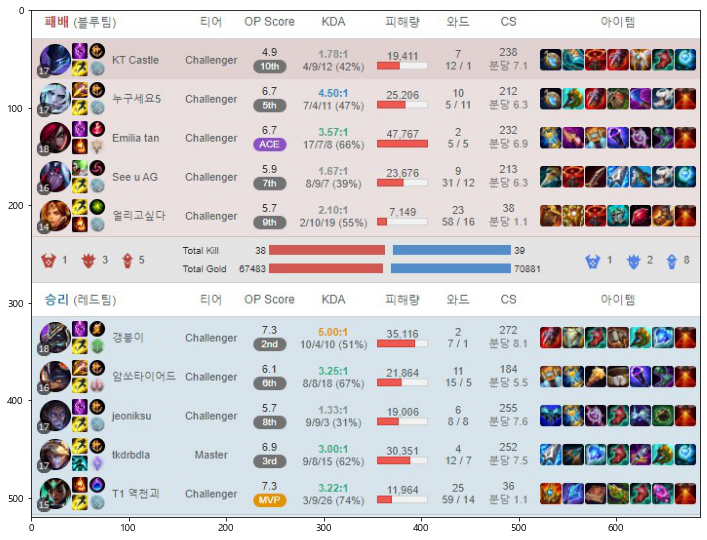

상대적_킬  상대적_데스  상대적_어시스트  상대적_레벨  첫킬   상댸적_돈  역할  상대적_가한피해량  상대적_받은피해량  \
0   -3.6     1.2       0.6     0.6   0  -351.6   3    -5230.8     2861.8   
1   -0.6    -3.8      -0.4     0.6   0   741.4   1      564.2    12097.8   
2    9.4    -0.8      -3.4     1.6   0  3834.4   2    23125.2    -3638.2   
3    0.4     1.2      -4.4    -0.4   0   141.4   0     -965.8    -7245.2   
4   -5.6     2.2       7.6    -2.4   0 -4365.6   4   -17492.8    -4076.2   
5    2.2    -3.6      -4.4     1.4   0  2629.8   3    11455.8     8372.6   
6    0.2     0.4       3.6    -0.6   0  -625.2   1    -1796.2     1236.6   
7    1.2     1.4     -11.4     0.4   0   149.8   2    -4654.2     4655.6   
8    1.2     0.4       0.6     0.4   1  2089.8   0     6690.8    -6455.4   
9   -4.8     1.4      11.6    -1.6   0 -4244.2   4   -11696.2    -7809.4   

   상대적_포인트  상대적_구매한 와드 수  
0     72.0          -3.2  
1    -96.0          -0.2  
2     85.0          -8.2  
3     48.0          -1.2  
4   -109.0          12.8  
5     85.6          -7.6  
6   -129.4           1.4  
7     78.6          -3.6  
8     80.6          -5.6  
9   -115.4          15.4

In [33]:
USER_NAME = 'KT Castle'
user = userInfo(USER_NAME)
saveMatchInfo(matches(user['puuid'], 0, 1)[0])
info = matchInfo(USER_NAME)[0]['info']
data = []
for user in info['participants']:
    row = []
    for col in ['kills', 'deaths', 'assists', 'champLevel', 'firstBloodKill', 'goldEarned', 'individualPosition', 'totalDamageDealtToChampions', 'totalDamageTaken', 'totalMinionsKilled', 'visionWardsBoughtInGame']:
        row.append(user[col])
    data.append(row)
df_test = pd.DataFrame(data, columns=columns)
for label in ['첫킬','역할']:
    df_test[label] = lr.fit_transform(df_test[label])

for idx in range(0, len(df_test), 5):
    for col in set(columns) - set(['역할', '첫킬']): 
        avg = np.mean(df_test.loc[idx:idx+4,col])
        df_test.loc[idx:idx+4,col] -= avg

image = img.imread('./imgs/experiment_2.jpg')
plt.figure(figsize=(12,12))
plt.imshow(image)
plt.show()

df_test

 추출한 무작위 데이터를 가지고 예측

In [34]:
ANSWER = ['BOTTOM', 'JUNGLE', 'MIDDLE', 'TOP', 'UTILITY']

df_test_x = df_test.drop('역할', axis=1)
df_test_y = df_test.역할

pred = rf_random.predict(df_test_x) - 1
for i in range(len(pred)):
    print('predict: {0}, answer: {1}'.format(ANSWER[pred[i]], ANSWER[df_test_y[i]]))
accuracy = round(float(accuracy_score(df_test_y, pred)) * 100, 2)
print(f'정확도 {accuracy}%')

predict: TOP, answer: TOP
predict: JUNGLE, answer: JUNGLE
predict: MIDDLE, answer: MIDDLE
predict: BOTTOM, answer: BOTTOM
predict: UTILITY, answer: UTILITY
predict: TOP, answer: TOP
predict: JUNGLE, answer: JUNGLE
predict: TOP, answer: MIDDLE
predict: BOTTOM, answer: BOTTOM
predict: UTILITY, answer: UTILITY
정확도 90.0%


'역할'을 예측하기위한 데이터 중요도

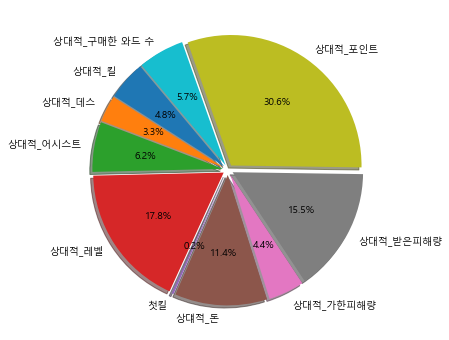

In [35]:
importances = list(rf_random.best_estimator_.feature_importances_)
labels = x_data.columns
plt.pie(importances, labels=labels, autopct='%.1f%%', explode=[0.04]*len(labels), shadow=True, startangle=130)
plt.show()

## 실험2 결론  
게임 내에서 '역할'이 나뉘는 확실한 기준 데이터는 없지만  
여러가지 데이터를 조합하다보면 어느정도 예측이 가능하다는 결론.  
'포인트'의 경우 게임내에서 수량이 한정되어있기때문에  
특정 포지션('MIDDLE', 'BOTTOM')에 몰아주다보니 중요도가 높은 것 같고  
'레벨'이나 '돈' 또한 같은 맥락으로 특정 포지션에 높게 측정되어 예측이 되는 것 같다.

# 실험 3
데이터들을 가지고 유저의 돈을 예측

In [5]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

df_gold = df[['게임시간', '킬', '어시스트', '첫킬', '포인트', '구매한 와드 수', '돈']].copy()
df_gold

게임시간   킬  어시스트  첫킬  포인트  구매한 와드 수      돈
0      2050   9    14   0  119         2  11821
1      2050  16    13   0   57         4  17274
2      2050  10    14   0  156         3  15465
3      2050   9    12   0  227         5  16835
4      2050   7    25   1   49         8  11895
...     ...  ..   ...  ..  ...       ...    ...
34635  1298   2     4   0  112         1   6682
34636  1298   8     4   0  152         4   9113
34637  1298   4     6   0   22         9   7929
34638  1298   6     8   0  140         3   9301
34639  1298   3    15   1   26         5   6626

[34640 rows x 7 columns]

모델 생성 및 예측, 평균 오차값 출력

In [27]:
from sklearn.metrics import mean_squared_error
import numpy as np
os.environ["PATH"]+=os.pathsep+'D:/Storage/Program/Graphviz/bin/'
x_data = df_gold.drop('돈', axis=1)
y_data = df_gold.돈
x_train, x_test, y_train, y_test= train_test_split(x_data, y_data, test_size=0.2, random_state=2)
reg_model = DecisionTreeRegressor(max_depth=6)
reg_model.fit(x_train, y_train)
pred = reg_model.predict(x_test)
mean_error = np.sqrt(mean_squared_error(y_test, pred))
print('평균 오차값: {0}'.format(round(mean_error)))

평균 오차값: 1043


모델의 트리구조를 렌더링

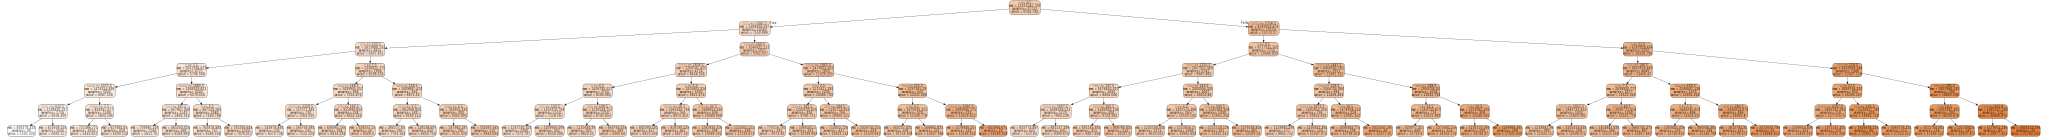

In [28]:
import graphviz, os
from sklearn.tree import export_graphviz

export_graphviz(reg_model, out_file='reg_tree.dot', feature_names=x_data.columns,  filled=True, rounded=True)
with open('./reg_tree.dot', 'r', encoding='utf8') as file:
    dot_graph = file.read()
display(graphviz.Source(dot_graph))

# 실험 4 
동물 사진 분류 모델 생성

데이터 전처리: 이미지 확장자 통일, 이미지 양산

In [ ]:
import glob, path, os, time
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

IMG_PATH = './imgs/'

IMAGE_GEN_COUNT = 5

np.random.seed(5)
data_aug_gen = ImageDataGenerator(rescale=1./255, 
                                  rotation_range=20,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.5,
                                  zoom_range=[1.0, 1.5],
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  fill_mode='constant')
def imageToJpg(rename_ext='png'):
    for img_name in IMG_NAMES:
        for img_path in glob.glob(os.path.join(IMG_PATH + img_name, '*.' + rename_ext)):
            new_path = img_path.split(rename_ext)[0] + 'jpg'
            os.rename(img_path, new_path)
def imageGenerate(data_aug_gen, image_gen_count=3)
for img_name in CATEGORIES:
    for img_path in glob.glob(os.path.join(IMG_PATH + img_name, '*.jpg')):
        img = load_img(img_path)
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)
        for i, batch in enumerate(data_aug_gen.flow(x, batch_size=1, save_to_dir='imgs/'+img_name, save_prefix='tri', save_format='jpg')):
            if (i + 1) == image_gen_count: break
imageToJpg()
imageGenerate(data_aug_gen, IMAGE_GEN_COUNT)

이미지 불러오기 및 학습

In [6]:
import glob, os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.models import load_model
import tensorflow as tf

def image_to_data(img_path, img_size=(64,64), image_color='RGB'):
    img = Image.open(img_path).convert(image_color).resize((img_size[0], img_size[1]))
    data = np.asarray(img)
    return data
def file_names(dir_path, file_ext='jpg'):
    file_names = glob.glob(os.path.join(dir_path, '*.' + file_ext))
    return file_names
def datasets(categories, **kwargs):
    if not 'file_ext' in kwargs: kwargs['file_ext'] = 'jpg'
    if not 'img_size' in kwargs: kwargs['img_size'] = (64, 64)
    if not 'img_path' in kwargs: kwargs['img_path'] = './'
    if not 'save' in kwargs: kwargs['save'] = False
    if not 'save_path' in kwargs: kwargs['save_path'] = './data.npy'
    if not 'image_color' in kwargs: kwargs['image_color'] = 'RGB'

    if kwargs['img_path'][len(kwargs['img_path']) - 1] != '/':  kwargs['img_path'] += '/'

    X = []; Y = []
    for i, cate in enumerate(categories):
        label = [0 for i in range(len(categories))]
        label[i] = 1
        for j, file_name in enumerate(file_names(kwargs['img_path'] + cate, kwargs['file_ext'])):
            X.append(image_to_data(file_name, kwargs['img_size'], kwargs['image_color']))
            Y.append(label)
    X = np.array(X); Y = np.array(Y)
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.05, stratify=Y)

    if kwargs['save'] == True: np.save(kwargs['save_path'], (x_train, x_test, y_train, y_test))
    else: return (x_train, x_test, y_train, y_test)
def fit(file_name, X, Y, categories):
    if file_name[-3:] != '.h5': file_name += '.h5'
    
    with tf.device('/gpu:0'):
        model = Sequential()
        model.add(Conv2D(16, kernel_size=(3,3), padding='same', input_shape=X.shape[1:], activation='relu'))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(0.25))

        model.add((Conv2D(32, (3,3), padding='same', activation='relu')))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(0.25))

        model.add((Conv2D(64, (3,3), padding='same', activation='relu')))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(0.25))

        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(len(categories), activation='softmax'))

        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        model.fit(X, Y, epochs=5, batch_size=32)
        model.save(file_name)
def makeModel(categories):
    datasets(categories, img_path='./imgs', save=True, save_path='data.npy')
    x_train, x_test, y_train, y_test = np.load('data.npy', allow_pickle=True)
    fit('model', x_train, y_train, CATEGORIES)

CATEGORIES = ['cat', 'dog', 'wild']

makeModel(CATEGORIES)

D:\Storage\Program\Anaconda\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
Epoch 1/5
479/479 [==============================] - 6s 10ms/step - loss: 15.3186 - accuracy: 0.3635
Epoch 2/5
479/479 [==============================] - 6s 12ms/step - loss: 1.0257 - accuracy: 0.4336
Epoch 3/5
479/479 [==============================] - 5s 10ms/step - loss: 0.8819 - accuracy: 0.5893
Epoch 4/5
479/479 [==============================] - 5s 10ms/step - loss: 0.7225 - accuracy: 0.6816
Epoch 5/5
479/479 [==============================] - 5s 11ms/step - loss: 0.6181 - accuracy: 0.7519


학습된 모델로 test 데이터 예측

In [9]:
def predict(model, categories, X, **kwargs):
    if type(X) == type([]): X = np.array(X)
    length = len(X)

    correct = 0
    if 'answers' in kwargs:
        for x, y in zip(model.predict(X), kwargs['answers']):
            if np.argmax(x) == np.argmax(y): correct += 1
        fail = length - correct
        percent = round((correct / length) * 100, 2)
        print('({0} / {1}) 정답. {2}%'.format(correct, length, percent))
    else:
        return [categories[np.argmax(x)] for x in model.predict(X)]

_,x_test,_,y_test = np.load('data.npy', allow_pickle=True)
model = load_model('model.h5')
predict(model, CATEGORIES, x_test, answers=y_test)

(807, 64, 64, 3)
(690 / 807) 정답. 85.5%


인터넷에서 무작위로 다운받은 이미지 예측

(1, 64, 64, 3)


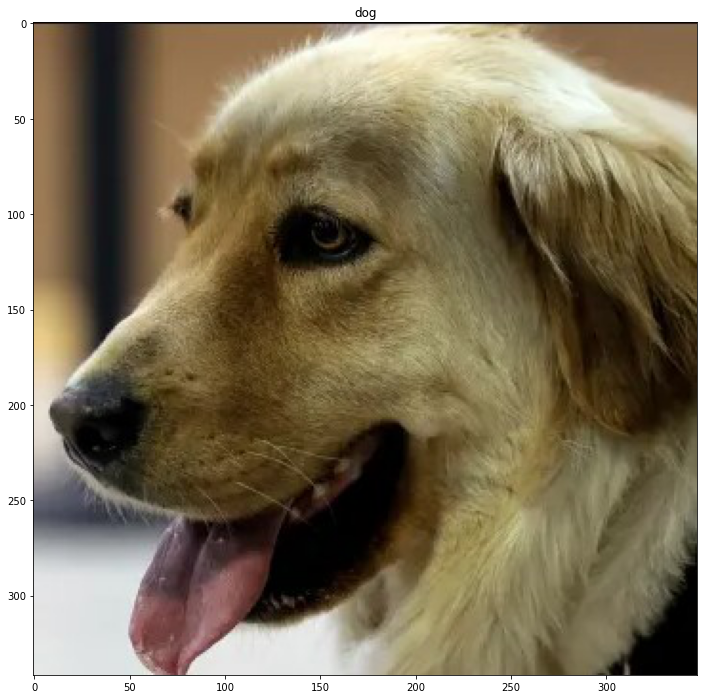

dog


In [48]:
import matplotlib.image as img
import matplotlib.pyplot as plt

IMAGE_NAME = 'tmp1.jpg'
ans = predict(model, CATEGORIES, [image_to_data(IMAGE_NAME)])[0]
image = img.imread('./' + IMAGE_NAME)
plt.figure(figsize=(12,12))
plt.imshow(image)
plt.title(ans)
plt.show()
print('==============')
print(ans)
print('==============')

(1, 64, 64, 3)


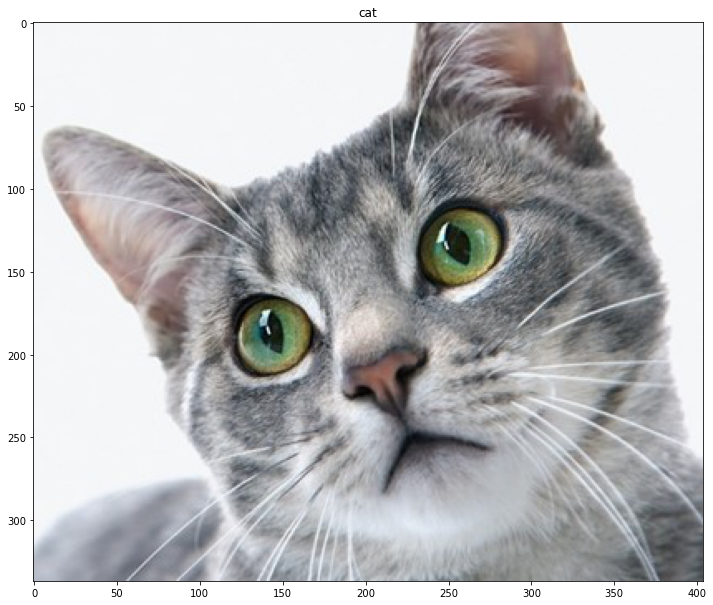

cat


In [46]:
IMAGE_NAME = 'tmp2.jpg'
ans = predict(model, CATEGORIES, [image_to_data(IMAGE_NAME)])[0]
image = img.imread('./' + IMAGE_NAME)
plt.figure(figsize=(12,12))
plt.imshow(image)
plt.title(ans)
plt.show()
print('==============')
print(ans)
print('==============')

(1, 64, 64, 3)


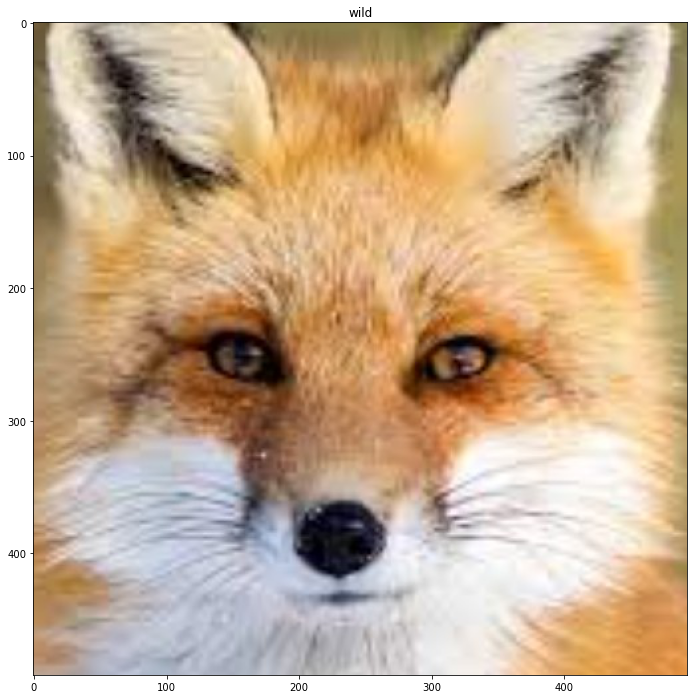

wild


In [47]:
IMAGE_NAME = 'tmp3.jpg'
ans = predict(model, CATEGORIES, [image_to_data(IMAGE_NAME)])[0]
image = img.imread('./' + IMAGE_NAME)
plt.figure(figsize=(12,12))
plt.imshow(image)
plt.title(ans)
plt.show()
print('==============')
print(ans)
print('==============')